# Objective :  Annual Water usage in Baltimore

### Steps of the Process

1. Problem Description. 

2. Test Harness.

3. Persistence.

4. Data Analysis.

5. ARIMA Models.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import warnings
from pandas import Grouper
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMAResults 

In [3]:
def get_data():
    return pd.read_csv('water.csv', index_col = 0, header = 0, squeeze = True, parse_dates = True)

In [4]:
series = get_data()
len(series)

79

In [5]:
series

Year
1885-01-01    356
1886-01-01    386
1887-01-01    397
1888-01-01    397
1889-01-01    413
1890-01-01    458
1891-01-01    485
1892-01-01    344
1893-01-01    390
1894-01-01    360
1895-01-01    420
1896-01-01    435
1897-01-01    439
1898-01-01    454
1899-01-01    462
1900-01-01    454
1901-01-01    469
1902-01-01    500
1903-01-01    492
1904-01-01    473
1905-01-01    458
1906-01-01    469
1907-01-01    481
1908-01-01    488
1909-01-01    466
1910-01-01    462
1911-01-01    473
1912-01-01    530
1913-01-01    662
1914-01-01    651
             ... 
1934-01-01    492
1935-01-01    503
1936-01-01    515
1937-01-01    500
1938-01-01    522
1939-01-01    575
1940-01-01    583
1941-01-01    587
1942-01-01    628
1943-01-01    640
1944-01-01    609
1945-01-01    606
1946-01-01    632
1947-01-01    617
1948-01-01    613
1949-01-01    598
1950-01-01    575
1951-01-01    564
1952-01-01    549
1953-01-01    538
1954-01-01    568
1955-01-01    575
1956-01-01    579
1957-01-01    587
1958-

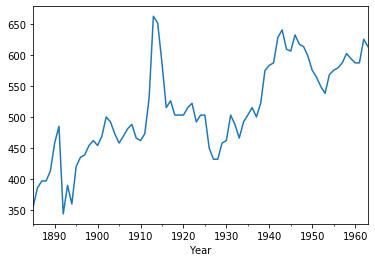

In [6]:
series.plot()

In [7]:
test_size = len(series)-10
dataset, validation = series[0: test_size], series[test_size:]

# Persistence Model

In [15]:
X = dataset.values
X = X.astype('float32')
train_size = int(len(X) * 0.5)

train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    y_hat = history[-1]
    predictions.append(y_hat)
    observation = test[t]
    history.append(observation)
    print("Predicted Value",y_hat,"Actual Value", observation, sep = " : ")
rmse = math.sqrt(mean_squared_error(test,predictions))    
print("RMSE", rmse, sep = " : ")
    

Predicted Value : 503.0 : Actual Value : 503.0
Predicted Value : 503.0 : Actual Value : 503.0
Predicted Value : 503.0 : Actual Value : 515.0
Predicted Value : 515.0 : Actual Value : 522.0
Predicted Value : 522.0 : Actual Value : 492.0
Predicted Value : 492.0 : Actual Value : 503.0
Predicted Value : 503.0 : Actual Value : 503.0
Predicted Value : 503.0 : Actual Value : 450.0
Predicted Value : 450.0 : Actual Value : 432.0
Predicted Value : 432.0 : Actual Value : 432.0
Predicted Value : 432.0 : Actual Value : 458.0
Predicted Value : 458.0 : Actual Value : 462.0
Predicted Value : 462.0 : Actual Value : 503.0
Predicted Value : 503.0 : Actual Value : 488.0
Predicted Value : 488.0 : Actual Value : 466.0
Predicted Value : 466.0 : Actual Value : 492.0
Predicted Value : 492.0 : Actual Value : 503.0
Predicted Value : 503.0 : Actual Value : 515.0
Predicted Value : 515.0 : Actual Value : 500.0
Predicted Value : 500.0 : Actual Value : 522.0
Predicted Value : 522.0 : Actual Value : 575.0
Predicted Val

# Data Analysis

In [16]:
dataset.describe()

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: Water, dtype: float64

### Observation : 

 - There are a total of 69 values in the dataset
 - The minimum usage of water is 344 units of liters per capita per day
 - The maximum usage goes to 662 units of liters per capita per day

### Line Plot

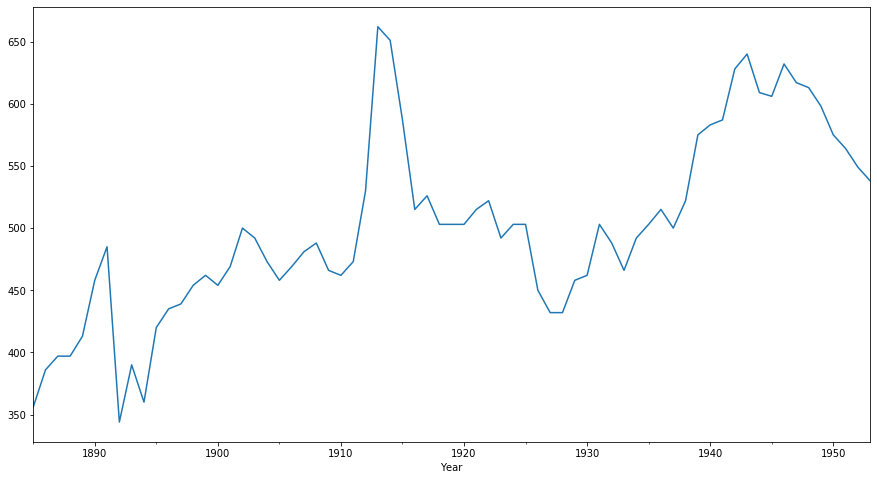

In [18]:
plt.figure(figsize = (15,8))
dataset.plot()
plt.show()

### Observation : 

 - There seems to be an increasing trend in the water usage across the years
 - The last few years of dataset, seem to have a decreasing trend
 - There seems no seasonality at first, but this will be looked into more detail at the end
 
 
 Since there is a trend component in the time series, the time series is not stationary, and thus we will have to apply differencing to make it stationary

### Density Plots

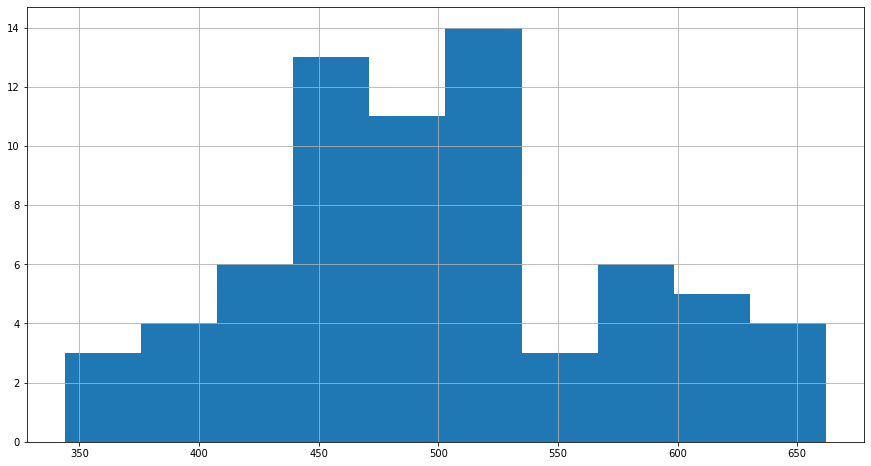

In [21]:
plt.figure(figsize = (15,8))
dataset.hist()
plt.show()

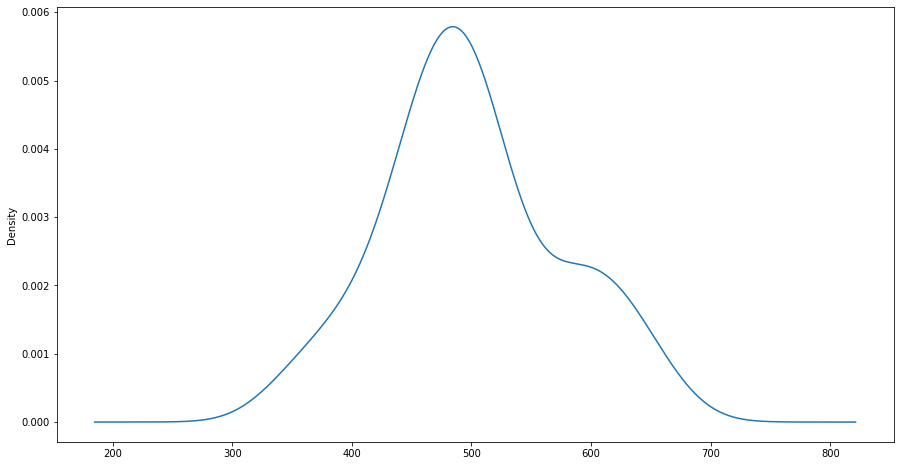

In [22]:
plt.figure(figsize = (15,8))
dataset.plot(kind = 'kde')
plt.show()

### Box And Whisker Plots

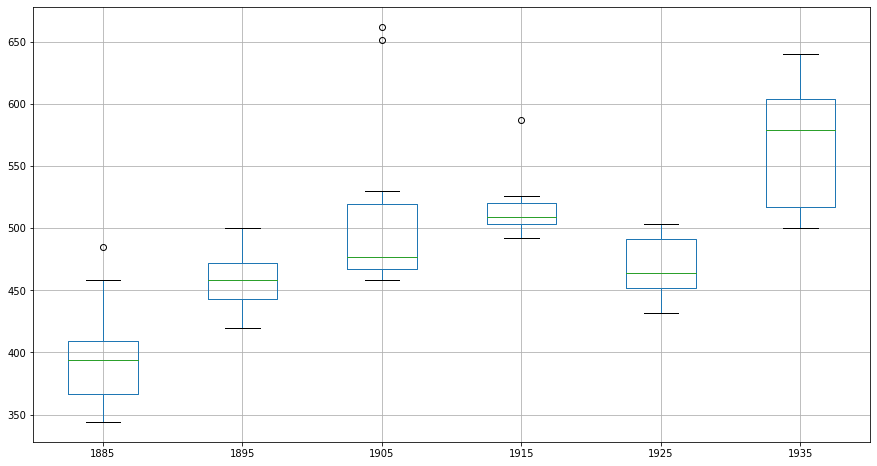

In [30]:
groups = dataset['1885':'1953'].groupby(Grouper(freq = '10YS'))
decades = pd.DataFrame()
for name,group in groups:
    if len(group.values) == 10:
        decades[name.year] = group.values
plt.figure(figsize = (15,8))        
decades.boxplot()
plt.show()

### Summary Statistics from Decade to Decade

In [31]:
decades

,1885,1895,1905,1915,1925,1935
0,356,420,458,587,503,503
1,386,435,469,515,450,515
2,397,439,481,526,432,500
3,397,454,488,503,432,522
4,413,462,466,503,458,575
5,458,454,462,503,462,583
6,485,469,473,515,503,587
7,344,500,530,522,488,628
8,390,492,662,492,466,640
9,360,473,651,503,492,609


In [40]:
def get_summary_stats(decades):
    summary_stats = []
    for i in range(decades.shape[1]):
        summary_stats.append(decades.iloc[:,i].describe())
    return pd.concat(summary_stats, axis = 1)

In [41]:
summary_10Y = get_summary_stats(decades)
summary_10Y

,1885,1895,1905,1915,1925,1935
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,398.600000,459.800000,514.000000,516.900000,468.600000,566.200000
std,44.377672,24.979102,77.848856,26.714332,26.829503,52.537394
min,344.000000,420.000000,458.000000,492.000000,432.000000,500.000000
25%,366.500000,442.750000,466.750000,503.000000,452.000000,516.750000
50%,393.500000,458.000000,477.000000,509.000000,464.000000,579.000000
75%,409.000000,472.000000,519.500000,520.250000,491.000000,603.500000
max,485.000000,500.000000,662.000000,587.000000,503.000000,640.000000


# Arima Model : Manually Configured

Before we develop an ARIMA model, we check for stationarity in the series, and we can do that by using the adfuller test on top of the differencing method
After we are done checking the stationarity of the dataset, we will then plot autocorrelation plots and partial-autorcorrelation plots

In [44]:
def difference_series(dataset):
    differenced = [dataset[i] -  dataset[i-1] for i in range(1, len(dataset))]
    return differenced


X = dataset.values
X = X.astype('float32')
differenced  = difference_series(X)
result = adfuller(differenced)

print("ADF Statsistic",result[0], sep = " : ")
print("p Value", result[1], sep = " : ")
for key, value in result[4].items():
    print(key,value, sep = " : ")

ADF Statsistic : -6.126718808474715
p Value : 8.593851954694127e-08
1% : -3.5335601309235605
5% : -2.9064436883991434
10% : -2.590723948576676


`Conclusion` : 


We can easily reject the null hypothesis here, and conclude that after differencing there seems to be no stationarity present in the series, or in other words there seems to be no temporal structure present in the dataset

### Autocorrelation Plots and Partial Autocorrelation Plots :  Dataset

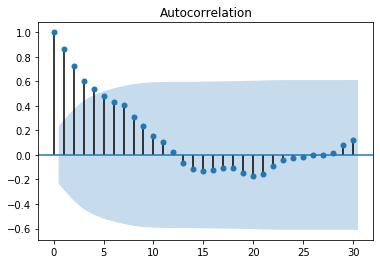

In [52]:
plot_acf(pd.DataFrame(dataset), lags = 30)
plt.show()

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


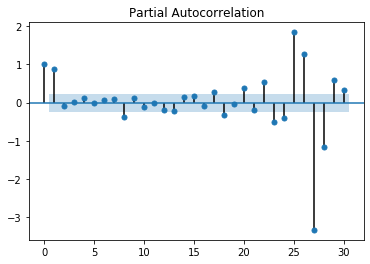

In [53]:
plot_pacf(pd.DataFrame(dataset), lags = 30)
plt.show()

### Observation  :  

 - There seems to be statistical significant relationship between the lag variables (0-5) Plot 1 - Autocorrelation
 - There seems to be statistical significant relationship between the lag variables (0-2) Plot 2 - Partial-Autocorrelation


### Autocorrelation Plots and Partial Autocorrelation Plots :  Differenced Series

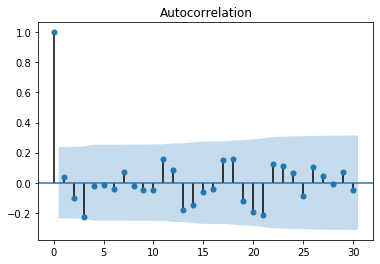

In [50]:
plot_acf(pd.DataFrame(differenced), lags = 30)
plt.show()

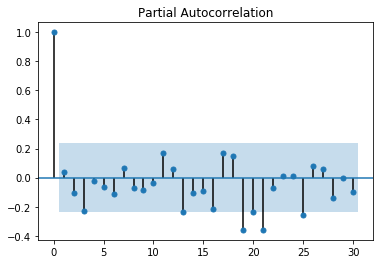

In [51]:
plot_pacf(pd.DataFrame(differenced), lags = 30)
plt.show()

### Observation  :  

 - There seems to be statistical significant relationship between the lag variables (0) Plot 1 - Autocorrelation
 - There seems to be statistical significant relationship between the lag variables (0) Plot 2 - Partial-Autocorrelation

Indicating that we have sqeezed out all the information we could from the dataset

### Automated ARIMA

### Configuration :
 - p_range : 0-5
 - d_range : 0-2
 - q_range : 0-5
 
 Setting these values will essentially perform different levels of differencing between number of lag variables and will give us results based on a moving average window of size q

In [59]:
def evaluate_arima(data, arima_order):
    X = dataset.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)

    train, test = X[0:train_size], X[train_size :]


    history = [x for x in train]
    
    predictions = []
    
    for t in range(len(test)):
        model = ARIMA(history, arima_order)
        model_fit = model.fit(trend = 'nc',disp = 0)
        y_hat  = model_fit.forecast()[0]
        
        observation = test[t]
        
        predictions.append(y_hat)
        history.append(observation)
        
    rmse =  math.sqrt(mean_squared_error(test,predictions))
    return rmse


In [60]:
def make_model(dataset, p_range, d_range, q_range):
    dataset = dataset.astype('float32')
    best_rmse, best_config = float('inf'),None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    rmse = evaluate_arima(dataset, (p,d,q))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_config  = (p,d,q)
                    print("Model RMSE", rmse, "Config", (p,d,q), sep = " : ")
                except:
                    continue
    print("Best RMSE", best_rmse, "Best Config", best_config, sep =  " : ")
    

In [61]:
p_range = range(0,5)
d_range = range(0,2)
q_range = range(0,5)
make_model(dataset, p_range, d_range, q_range)

Model RMSE : 282.6580177865594 : Config : (0, 0, 1)
Model RMSE : 77.29892415823127 : Config : (0, 0, 4)
Model RMSE : 21.90734100745434 : Config : (0, 1, 1)
Model RMSE : 22.182030407974256 : Config : (0, 1, 2)
Model RMSE : 24.732854112011566 : Config : (0, 1, 3)
Model RMSE : 24.84506136414902 : Config : (0, 1, 4)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'avai

Model RMSE : 22.061377500935 : Config : (1, 0, 0)
Model RMSE : 21.921720559925497 : Config : (1, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

Model RMSE : 22.26575816141482 : Config : (2, 0, 0)
Model RMSE : 21.732610507221565 : Config : (2, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Model RMSE : 21.97104747254528 : Config : (3, 0, 0)
Model RMSE : 24.26968524569842 : Config : (3, 1, 0)
Model RMSE : 25.49117398977829 : Config : (3, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_par

Model RMSE : 24.25313010211237 : Config : (4, 0, 0)
Model RMSE : 24.80212466795521 : Config : (4, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

Model RMSE : 25.103421630406196 : Config : (4, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization

Model RMSE : 24.95609183035536 : Config : (4, 1, 2)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse

Best RMSE : 21.732610507221565 : Best Config : (2, 1, 0)


### NOTE  :

Since now we have finalized our model :  ARIMA (2,1,0), we will look at the residual errors

In [66]:
def evaluate_arima(data, arima_order):
    X = dataset.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)

    train, test = X[0:train_size], X[train_size :]


    history = [x for x in train]
    
    predictions = []
    
    for t in range(len(test)):
        model = ARIMA(history, arima_order)
        model_fit = model.fit(trend = 'nc',disp = 0)
        y_hat  = model_fit.forecast()[0]
        
        observation = test[t]
        
        predictions.append(y_hat)
        history.append(observation)
        
    rmse =  math.sqrt(mean_squared_error(test,predictions))
    print("RMSE", rmse, sep = "  : ")
    return (predictions,test)


In [67]:
arima_order = (2,1,0)
predictions,test  = evaluate_arima(dataset, arima_order)

RMSE  : 21.732610507221565


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cef8da0>]],
      dtype=object)

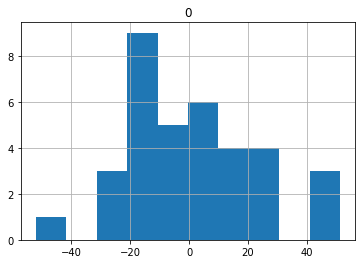

In [70]:
residuals = [test[i] - predictions[i] for i in range(len(test))]


pd.DataFrame(residuals).hist()


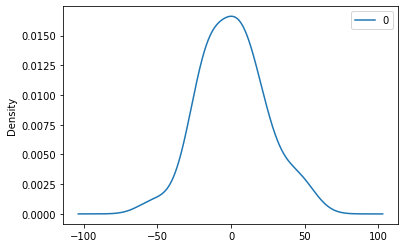

In [72]:

pd.DataFrame(residuals).plot(kind = 'kde')
plt.show()

In [73]:
pd.DataFrame(residuals).describe()

,0
count,35.000000
mean,1.081624
std,22.022566
min,-52.103812
25%,-16.202281
50%,-0.459803
75%,12.085091
max,51.284337


### Observation : 

The residuals do not perfectly belong to a Gaussian Distribution, and thus more information can be squeezed from the residuals

Another thing which can be done is create lag variables and use residuals from the model as a feature, to decrease the overall error, or use the mean residual error and add that to each prediction made

In [79]:
def evaluate_arima(data, arima_order):
    X = dataset.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)

    train, test = X[0:train_size], X[train_size :]


    history = [x for x in train]
    
    predictions = []
    bias = 1.081624
    for t in range(len(test)):
        model = ARIMA(history, arima_order)
        model_fit = model.fit(trend = 'nc',disp = 0)
        y_hat  = model_fit.forecast()[0]
        y_hat =  bias + float(y_hat)
        observation = test[t]
        
        predictions.append(y_hat)
        history.append(observation)
        
    rmse =  math.sqrt(mean_squared_error(test,predictions))
    print("RMSE", rmse, sep = "  : ")
    return (predictions,test)

In [80]:
arima_order = (2,1,0)
(predictions,test) = evaluate_arima(dataset, arima_order)

RMSE  : 21.705677786544477


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cf43ba8>]],
      dtype=object)

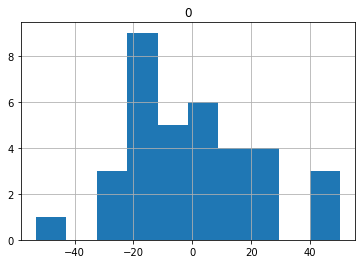

In [81]:
residuals = [test[i] - predictions[i] for i in range(len(test))]


pd.DataFrame(residuals).hist()

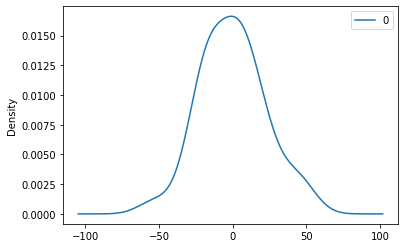

In [82]:
pd.DataFrame(residuals).plot(kind = 'kde')
plt.show()

In [83]:
pd.DataFrame(residuals).describe()

,0
count,3.500000e+01
mean,3.734804e-07
std,2.202257e+01
min,-5.318544e+01
25%,-1.728390e+01
50%,-1.541427e+00
75%,1.100347e+01
max,5.020271e+01


### OBSERVATION : 

The model's error is reduced in comparison to the previous approach

# Model Validation

In [84]:
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

In [90]:
X = dataset.values.astype('float32')

model  = ARIMA(X,(2,1,0))
model_fit = model.fit(trend = 'nc',disp = 0)
bias = 1.081624
model_fit.save('model_fit.pkl')
np.save("BIAS.npy",[bias])

### Validate Model

### Evaluation : Without BoxCox Tranformation

In [100]:
X = dataset.values.astype('float32')
y = validation.values.astype('float32')

model_fit = ARIMAResults.load('model_fit.pkl')
bias = np.load('BIAS.npy')[0]

history = [x for x in X]
predictions = []

model = ARIMAResults
y_hat = bias + float(model_fit.forecast()[0])

predictions.append(y_hat)
history.append(y[1])

for t in range(1, len(y)):
    model = ARIMA(history, (2,1,0))
    model_fit = model.fit(trend = 'nc', disp = 0)
    y_hat = bias + float(model_fit.forecast()[0])
    
    observation = y[t]
    
    history.append(observation)
    predictions.append(y_hat)
    
    print("Predicted Value", y_hat, "Actual Value", observation)
rmse = math.sqrt(mean_squared_error(y,predictions))    
print("RMSE",rmse,sep =  " : ")
    

Predicted Value 578.8884408177365 Actual Value 575.0
Predicted Value 572.223706406008 Actual Value 579.0
Predicted Value 580.2551141354718 Actual Value 587.0
Predicted Value 588.0280824895782 Actual Value 602.0
Predicted Value 602.9573385567564 Actual Value 594.0
Predicted Value 593.2161905572436 Actual Value 587.0
Predicted Value 588.5869567084118 Actual Value 587.0
Predicted Value 588.7953043549597 Actual Value 625.0
Predicted Value 627.7727701859694 Actual Value 613.0
RMSE : 16.539046442992


### Evaluation : With BoxCox Tranformation

In [97]:
def inverse_boxcox(lam, value):
    if lam == 0:
        return np.exp(value)
    else:
        return np.exp(np.log(lam * value + 1)/lam)

In [102]:
X = dataset.values.astype('float32')
transformed,lam = boxcox(X)

model  = ARIMA(transformed,(2,1,0))
model_fit = model.fit(trend = 'nc',disp = 0)
bias = 1.081624
model_fit.save('t_model_fit.pkl')
np.save('lambda.npy',[lam])
np.save("BIAS.npy",[bias])

In [119]:
X = dataset.values.astype('float32')
y = validation.values.astype('float32')

model_fit = ARIMAResults.load('t_model_fit.pkl')
lam = np.load('lambda.npy')
bias = np.load('BIAS.npy')[0]

history = [x for x in X]
predictions = []


y_hat = model_fit.forecast()[0]

y_hat = inverse_boxcox(lam,y_hat)

y_hat = bias + float(y_hat)


print("Predicted_Value", y_hat, "Actual Value", y[0])

predictions.append(y_hat)
history.append(y[0])

for t in range(1, len(y)):
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history,1
        
    model = ARIMA(transformed, (2,1,0))
    model_fit = model.fit(trend = 'nc', disp = 0)
    y_hat = float(model_fit.forecast()[0])
    
    y_hat = inverse_boxcox(lam,y_hat)
    y_hat = bias + float(y_hat)
    
    observation = y[t]
    
    history.append(observation)
    predictions.append(y_hat)
    
    print("Predicted Value", y_hat, "Actual Value", observation)
rmse = math.sqrt(mean_squared_error(y,predictions))    
print("RMSE",rmse,sep =  " : ")
    

Predicted_Value 540.0795086846839 Actual Value 568.0
Predicted Value 569.3222683031022 Actual Value 575.0
Predicted Value 573.9627720512376 Actual Value 579.0
Predicted Value 579.5914577644435 Actual Value 587.0
Predicted Value 587.8586161812988 Actual Value 602.0
Predicted Value 602.7128885314294 Actual Value 594.0
Predicted Value 593.6347922177422 Actual Value 587.0
Predicted Value 588.5795412448057 Actual Value 587.0
Predicted Value 588.7459395936988 Actual Value 625.0
Predicted Value 627.673144258111 Actual Value 613.0
RMSE : 16.56537737428001


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [108]:
pd.DataFrame(list(zip(y,predictions)))

,0,1
0,568.0,[2535430.7762170685]
1,575.0,576.198
2,579.0,573.512
3,587.0,580.078
4,602.0,587.829
5,594.0,602.653
6,587.0,593.666
7,587.0,588.608
8,625.0,588.747
9,613.0,627.516


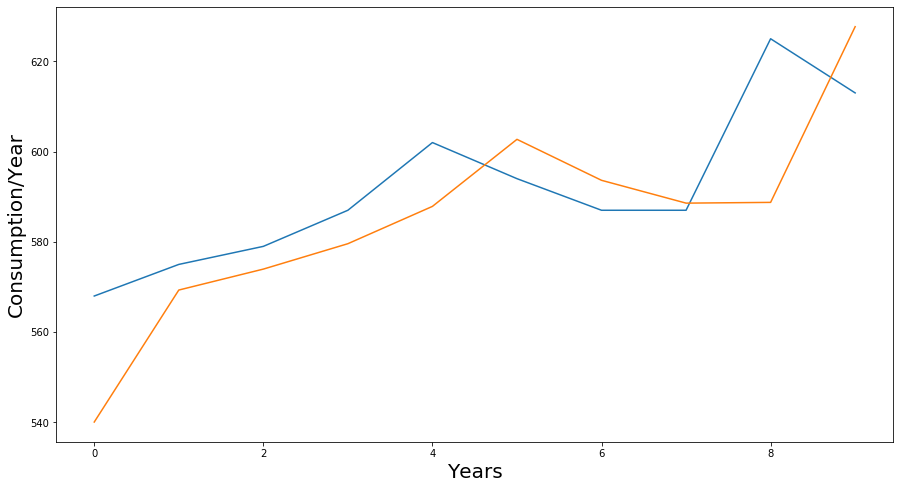

In [124]:
plt.figure(figsize = (15,8))
plt.plot(y)
plt.plot(predictions)
plt.ylabel('Consumption/Year', fontsize = 20)
plt.xlabel('Years', fontsize = 20)
plt.show()

# Conclusion : 
'

The model performs best when boxcox transform is not applied to the model and we instead use only the residual errors to make our forecasts